# Smoke Detector Alarm Classification

<div>
<img src="https://www.nicepng.com/png/full/767-7678230_wmd3-heat-detector-smoke-detector.png" width="420"/>
</div>

# 1. Frame the problem and look at the big picture

We want to create a model that recognises a fire alarm sound, the model is to be deployed on a smartphone, used in an app that will send a message to family/friends/neighbours when a fire alarm is recogniced. The fire alarm sounds are somewhat standarized, but there are different standards. Apple has a smoke detector recognition system, but it does not send alerts to friends famili, it could be used with shorcuts, but that may be a hassle to set up, especialy for older people. We will use supervised learning. The goal is to get the smoke detector alarm recognition as good as Apple´s solution. We will at least need to be able to recognize a firealarm with a standard frequenzy of 3100hz when the phone is in the same room, and idealy when the phone is in the users pocket, or even in a different room. For standard frequencies a non-ML model could possibly also be used, but a more flexible approach might me ideal.

Some Assumptions:
* Smoke detector signals are somewhat standarized
* Mobile phones let applications use the microphone while the app is in the background

# 2. Get the data

We will be creating our own dataset, by collecting sounds from smoke detectors online, and in person recording with the microphones on our phones. We need several hundred recordings, labeling them as smoke detector alarm sounds. Some of them sould be clear and uninterrupted sounds, others mixed with sound from the TV playing in the background, or music, etc. Other sounds will also need to be included, sounds that are not from a smoke detector but could sound like one, sirens from emergency veichles, microwave beeping when it finishes, etc. We will also need examples of sounds that are not of a smokedetector and does not sound like one, sounds that come from just walking around, watching tv, etc. Could also generate sounds from previous smokedetector sounds mixed with non smokedetector sounds.

Some smoke detector alarm sounds are taken from this dataset: https://research.google.com/audioset//dataset/smoke_detector_smoke_alarm.html

For training the models we will use the .wav file format.


# 3. Explore the data

## Intalling dependencies


In [ ]:
!sudo apt -y install libportaudio2
!pip install tflite-model-maker

## Import TensorFlow, Model Maker and other libraries

In [ ]:
import tensorflow as tf
import tflite_model_maker as mm
from tflite_model_maker import audio_classifier

import os
from google.colab import drive

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import itertools
import glob
import random

from IPython.display import Audio, Image
from scipy.io import wavfile

## The Smoke Detector Dataset

The dataset is a collection of smoke detector sounds, and non smoke detector sounds.

In [2]:
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
data_dir = '/content/drive/MyDrive/Skole/Høyskolen på Vestlandet/Bachelor/data'

In [4]:
for dirname, _, filenames in os.walk(data_dir):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/content/drive/MyDrive/Skole/Høyskolen på Vestlandet/Bachelor/data/train/SmokeDetector/BRK7010rookmelderResetenbatterijvervangen.wav
/content/drive/MyDrive/Skole/Høyskolen på Vestlandet/Bachelor/data/train/SmokeDetector/PruebadelSensorHumo.wav
/content/drive/MyDrive/Skole/Høyskolen på Vestlandet/Bachelor/data/train/SmokeDetector/SmokeDetectorSoundEffect.wav
/content/drive/MyDrive/Skole/Høyskolen på Vestlandet/Bachelor/data/train/SmokeDetector/SmokeDetectorAlarmSound69.wav
/content/drive/MyDrive/Skole/Høyskolen på Vestlandet/Bachelor/data/train/SmokeDetector/Sond_unealarmeincendie.wav
/content/drive/MyDrive/Skole/Høyskolen på Vestlandet/Bachelor/data/train/SmokeDetector/Oldsmokedetector.wav
/content/drive/MyDrive/Skole/Høyskolen på Vestlandet/Bachelor/data/train/SmokeDetector/SystemSensori3smokedetector.wav
/content/drive/MyDrive/Skole/Høyskolen på Vestlandet/Bachelor/data/train/SmokeDetector/smoke-alarm-sound.wav
/content/drive/MyDrive/Skole/Høyskolen på Vestlandet/Bachelor/da

## Ploting waves

In [5]:
RØYKVARSLER_FILE = os.path.join(data_dir, 'train', 'SmokeDetector', 'SmokeAlarmSound.wav')
IKKERØYKVARSLER_FILE = os.path.join(data_dir, 'train','NotSmokeDetector', 'MicrowaveBeeping.wav')

In [6]:
RØYKVARSLER_FILE

'/content/drive/MyDrive/Skole/Høyskolen på Vestlandet/Bachelor/data/train/SmokeDetector/SmokeAlarmSound.wav'

In [7]:
def show_data(audio_path):
  sample_rate, audio_data = wavfile.read(audio_path, 'rb')

  plttitle = audio_path.split('/')[-2]
  plt.title(plttitle)
  plt.plot(audio_data)

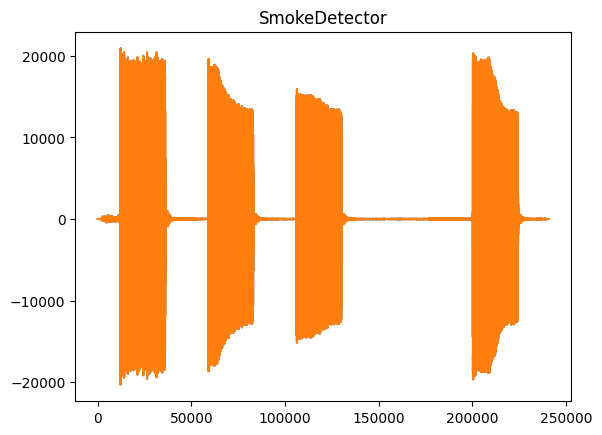

In [8]:
show_data(RØYKVARSLER_FILE)

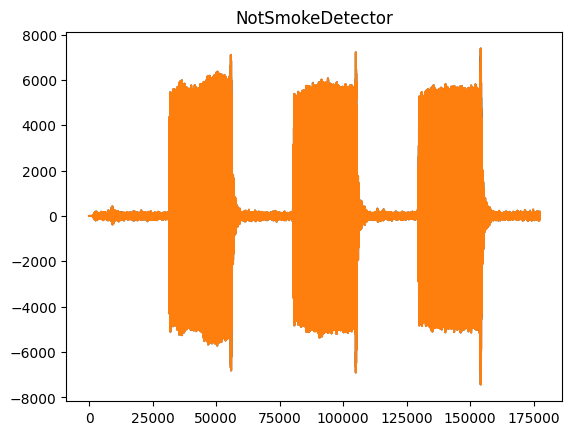

In [9]:
show_data(IKKERØYKVARSLER_FILE)

As we can se the smoke detector alarm is considerably louder than a microwave beeping, but they seem to be oscilating on and of at about the same rate.

# 4. Prepare the data

In [10]:
spec = audio_classifier.YamNetSpec(
    keep_yamnet_and_custom_heads=True,
    frame_step=2 * audio_classifier.YamNetSpec.EXPECTED_WAVEFORM_LENGTH,
    frame_length=6 * audio_classifier.YamNetSpec.EXPECTED_WAVEFORM_LENGTH)

## Loading the data

The data is structurer in 2 folders, one for training, and one for testing


In [11]:
train_data = audio_classifier.DataLoader.from_folder(spec, os.path.join(data_dir, 'train'), cache=True)
train_data, validation_data = train_data.split(0.8)
test_data = audio_classifier.DataLoader.from_folder(spec, os.path.join(data_dir, 'test'), cache=True)

# 5. Training the model

In [12]:
batch_size = 16
epochs = 100

print('Training the model')
model = audio_classifier.create(
    train_data,
    spec,
    validation_data,
    batch_size=batch_size,
    epochs=epochs)

Training the model
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 classification_head (Dense)  (None, 2)                2050      
                                                                 
Total params: 2,050
Trainable params: 2,050
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
12/12 [==============================] - 40s 2s/step - loss: 0.5655 - acc: 0.7598 - val_loss: 0.4056 - val_acc: 0.9062
Epoch 2/100
12/12 [==============================] - 0s 38ms/step - loss: 0.3053 - acc: 0.9441 - val_loss: 0.3099 - val_acc: 1.0000
Epoch 3/100
12/12 [==============================] - 1s 53ms/step - loss: 0.2171 - acc: 0.9553 - val_loss: 0.2502 - val_acc: 1.0000
Epoch 4/100
12/12 [==============================] - 1s 54ms/step - loss: 0.1508 - acc: 0.9721 - val_loss: 0.2134 - val_acc: 1.0000
Epoch 5/100
12/12 [=================

# 6. Evaluate

In [13]:
print('Evaluating the model')
model.evaluate(test_data)

Evaluating the model
1/1 [==============================] - 3s 3s/step - loss: 5.4317e-04 - acc: 1.0000


[0.0005431656027212739, 1.0]

## Confusion matrix

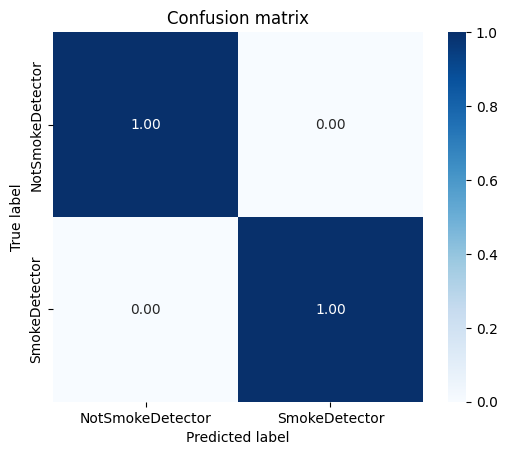

In [14]:
def show_confusion_matrix(confusion, test_labels):
  """Compute confusion matrix and normalize."""
  confusion_normalized = confusion.astype("float") / confusion.sum(axis=1)
  axis_labels = test_labels
  ax = sns.heatmap(
      confusion_normalized, xticklabels=axis_labels, yticklabels=axis_labels,
      cmap='Blues', annot=True, fmt='.2f', square=True)
  plt.title("Confusion matrix")
  plt.ylabel("True label")
  plt.xlabel("Predicted label")

confusion_matrix = model.confusion_matrix(test_data)
show_confusion_matrix(confusion_matrix.numpy(), test_data.index_to_label)

## 7. Export and deploy the model

In [15]:
models_path = './models'
print(f'Exporing the TFLite model to {models_path}')

model.export(models_path, tflite_filename='model.tflite')

Exporing the TFLite model to ./models
